# Quantum Walk Graph Classifier

今回の成果物である量子ウォークにおけるグラフの分類器に関するチュートリアル

In [1]:
import numpy as np
import random
import copy
import sys
import networkx as nx
import matplotlib.pyplot as plt

from numpy import pi
from tqdm import trange
from grakel import datasets, Graph
from sklearn.model_selection import KFold

sys.path.append("../")
from qwgc.QWGC import QWGC

/Users/ryosuke/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/ryosuke/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# 量子ウォーク

このプロジェクトにおける肝となる量子アルゴリズムである量子ウォークというものについてです。詳しくは我々の[プロジェクトページ](https://qwqmlf.github.io/QuantumFrontier/article)をご覧ください。今回は[MUTAG](https://rdrr.io/cran/QSARdata/man/mutagen.html)と呼ばれるデータセットを用いて、量子ウォークがグラフ上で行われるということがどういうことなのかということについて見ていきます。

In [2]:
# MUTAGを取ってくる
Data = datasets.fetch_dataset('MUTAG', verbose=False)
data_x, data_y = np.array(Data.data), np.array(Data.target)

まずはMUTAGとはどのようなデータなのかという点について見ていきます。代表として先頭10データを可視化していきたいと思います。

1


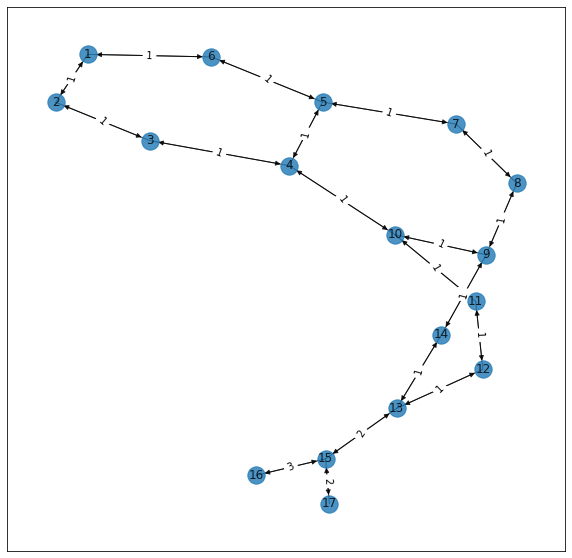

-1


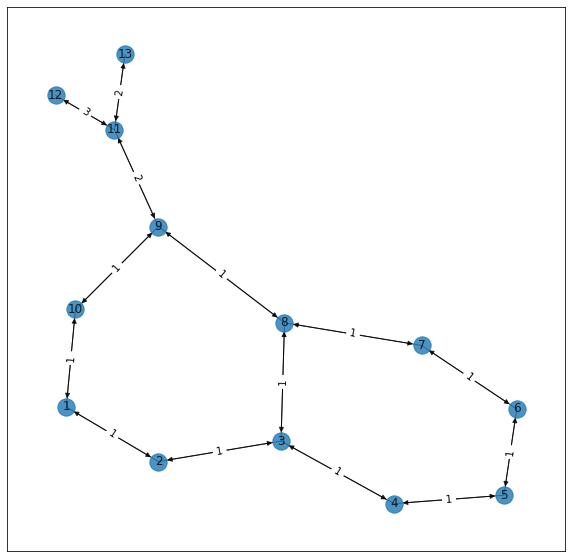

-1


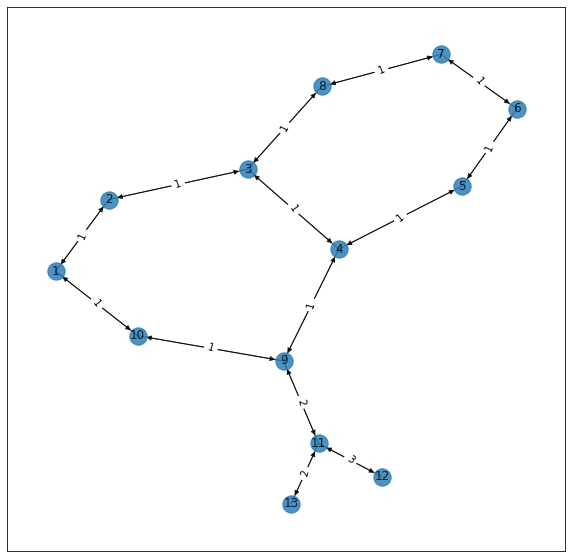

1


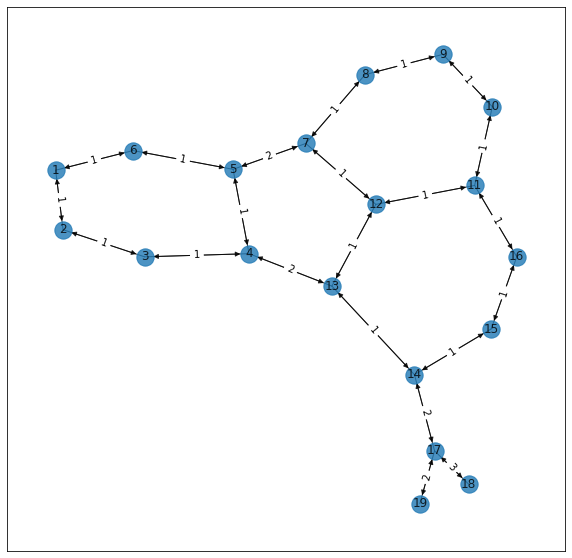

-1


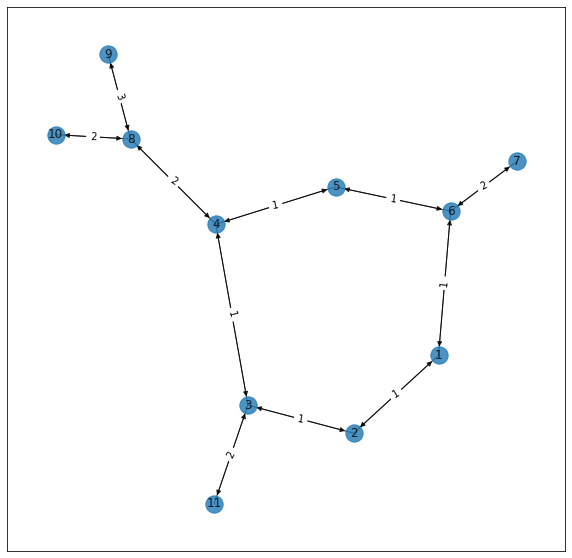

1


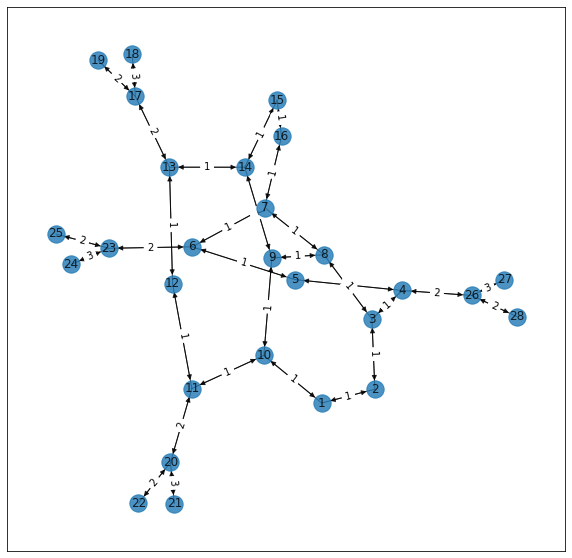

-1


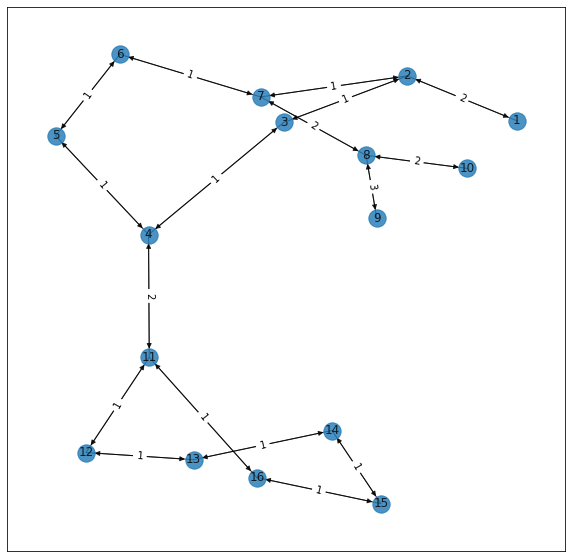

1


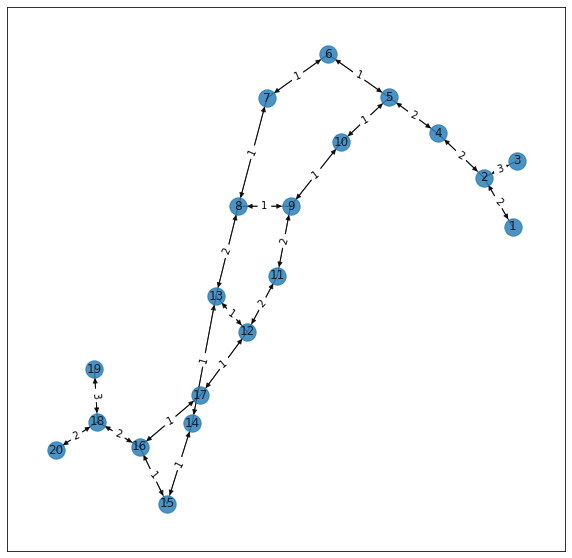

-1


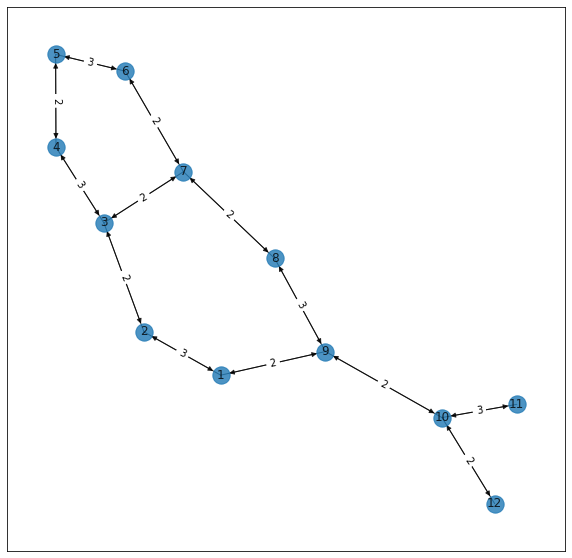

1


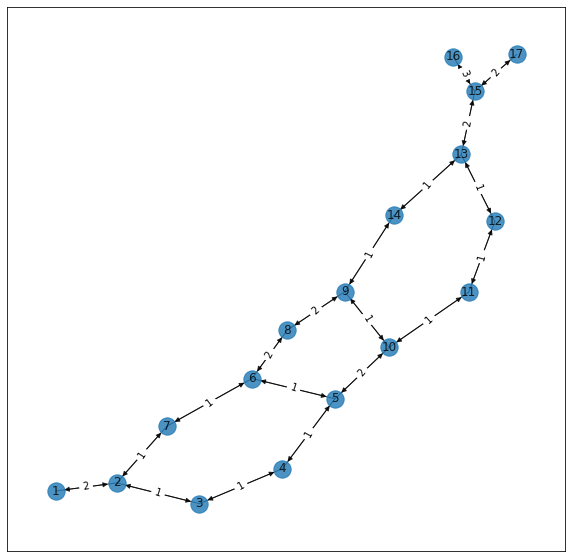

In [3]:
# visualization of data
subtract = 0
lens = []
for d, l in zip(data_x[:10], data_y[:10]):
    print(l)
    plt.figure(figsize=(10, 10))
    G = nx.DiGraph()
    connection = d[0]
    nodesize = [(i+1)**800 for i in d[1].values()]
    edge_weight = d[2]
    lens.append(len([i for i in d[1].values()]))
    adjacency = Graph(connection).get_adjacency_matrix()
    nodes = np.array([str(i+1) for i, _ in enumerate(adjacency)])
    edges = []
    weight = []
    for i, v in edge_weight.items():
        ed = [str(st-subtract) for st in list(i)]
        ed.append(v+1)
        edges.append(tuple(ed))
    subtract = max(d[1].keys())
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(edges)
    pos = nx.spring_layout(G)
    edge_labels = {(i, j): w['weight'] for i, j, w in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw_networkx(G, pos, with_labels=True, alpha=0.8)
    plt.show()

これらがMUTAGと呼ばれている変異原性があるのかないのかというデータセットになります。10から30程度のノード数を持ったグラフデータの集まりで、各ノードはある元素を表していて、各リンクは元素間の結合を表しています。各リンクの間についているラベルはその結合がどのような結合なのかということを表しています。ではここの上で量子ウォークを行うと、どのような状態がえられるのかということを見ていきたいと思います。

今回のプログラムはこちらの論文を参考としています。[Barr, Katie, Toby Fleming, and Viv Kendon. "Simulation methods for quantum walks on graphs applied to perfect state transfer and formal language recognition." Proceedings of the 2013 workshop on complex systems modelling and simulation, Milan, Italy. 2013.]

まずは量子ウォーカーが1ステップ進んだ時を考えます。スタートは全て0ノードです。

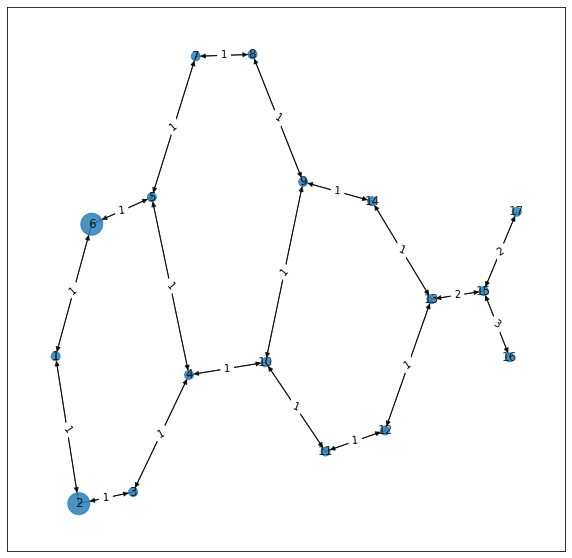

In [8]:
from qwgc.preprocess.qwalk import QuantumWalk
# 対象のデータ
data = data_x[0]
label = data_y[0]
# 隣接行列
adjacency = Graph(data[0]).get_adjacency_matrix()
count = np.count_nonzero(adjacency)//2
# 量子ウォークのハイパーパラメータ
step = 1
# 次数が2の場合のコインのパラメータ(今回は簡単のために全てアダマールコイン)
coin = np.kron(np.identity(count), 1/np.sqrt(2)*np.array([[1, 1], [1, -1]]))
# 初期状態 (0からスタート)
initial = None 
# 量子ウォーカーが測定される確率
qwalk = QuantumWalk(initial, coin, adjacency)
qwalk.n_steps(step)
probs = qwalk.calc_probs()

# 描画
plt.figure(figsize=(10, 10))
G = nx.DiGraph()
# ノードの大きさで確率を表す
connection = data[0]
nodesize = [(i+0.1)*800 for i in probs]
edge_weight = data[2]
nodes = np.array([str(i+1) for i, _ in enumerate(adjacency)])
edges = []
weight = []
for i, v in edge_weight.items():
    ed = [str(st) for st in list(i)]
    ed.append(v+1)
    edges.append(tuple(ed))
subtract = max(data[1].keys())
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)
pos = nx.spring_layout(G)
edge_labels = {(i, j): w['weight'] for i, j, w in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw_networkx(G, pos, with_labels=True, alpha=0.8, node_size=nodesize)
plt.show()

このように初期のノードから隣り合った二つのノードにおいて量子ウォーカーが観測されうるのがわかるかと思います。
もう少しステップを進めてみます。

In [13]:
def draw(nodesize):
    plt.figure(figsize=(10, 10))
    G = nx.DiGraph()
    # ノードの大きさで確率を表す
    connection = data[0]
    nodesize = [(i)*800 for i in probs]
    edge_weight = data[2]
    nodes = np.array([str(i+1) for i, _ in enumerate(adjacency)])
    edges = []
    weight = []
    for i, v in edge_weight.items():
        ed = [str(st) for st in list(i)]
        ed.append(v+1)
        edges.append(tuple(ed))
    subtract = max(data[1].keys())
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(edges)
    pos = nx.spring_layout(G)
    edge_labels = {(i, j): w['weight'] for i, j, w in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw_networkx(G, pos, with_labels=True, alpha=0.8, node_size=nodesize)
    plt.show()

../qwgc/preprocess/qwalk.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[i] += amps_at_j * np.conjugate(amps_at_j)


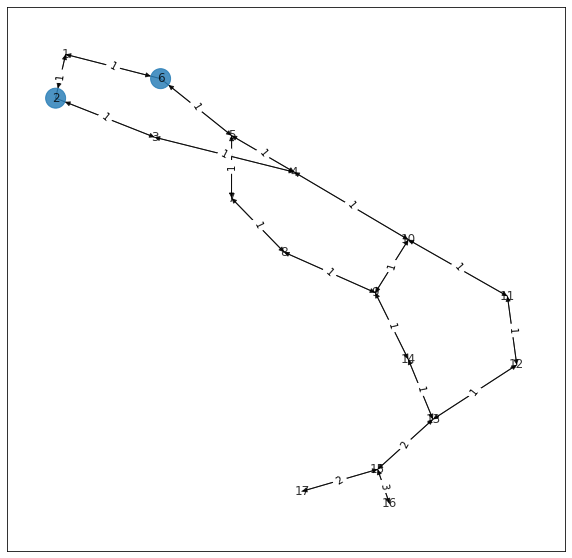

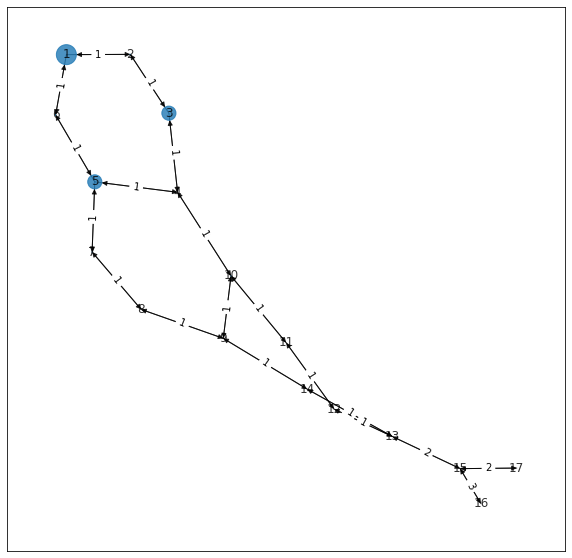

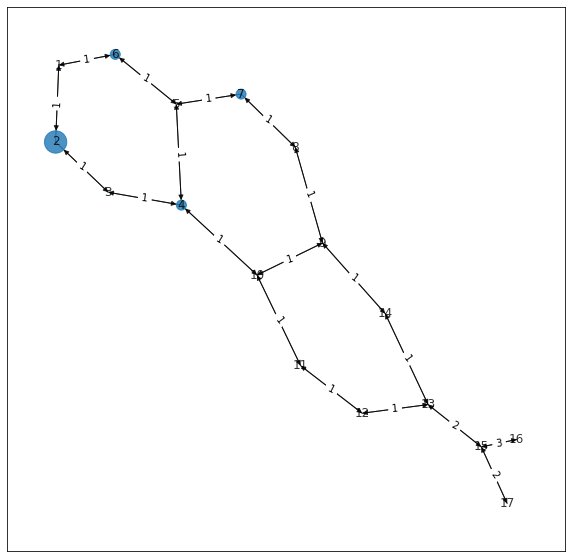

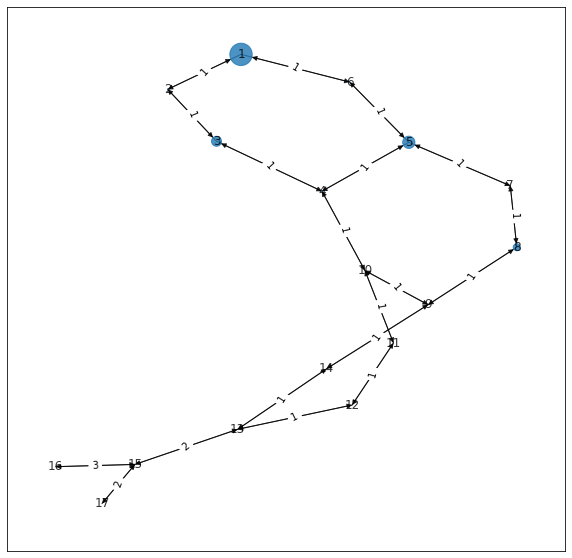

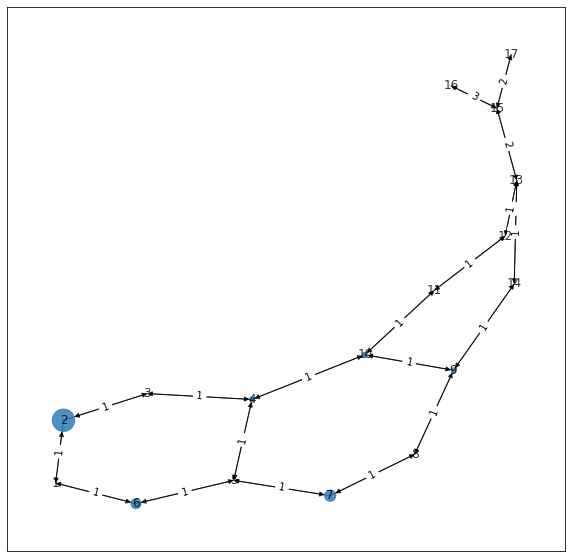

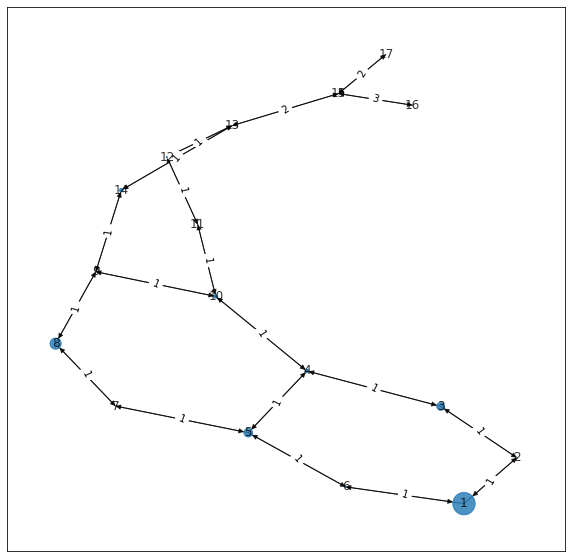

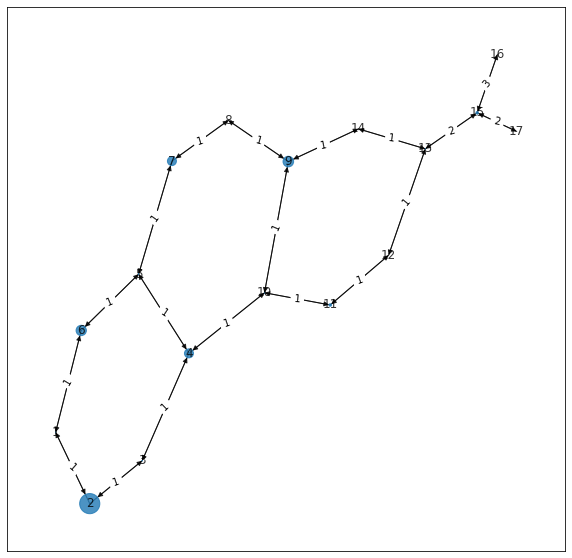

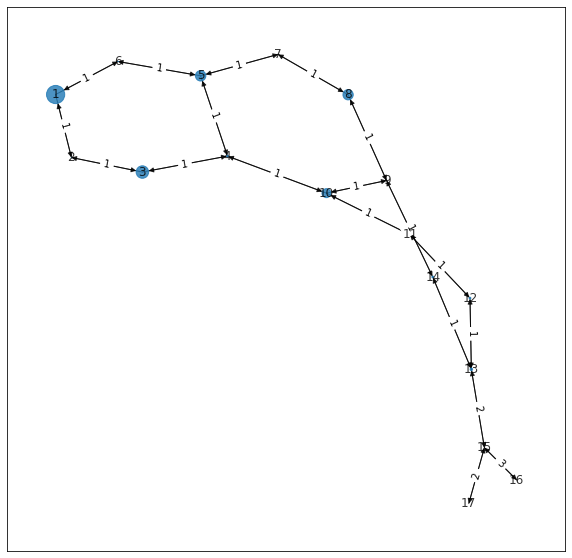

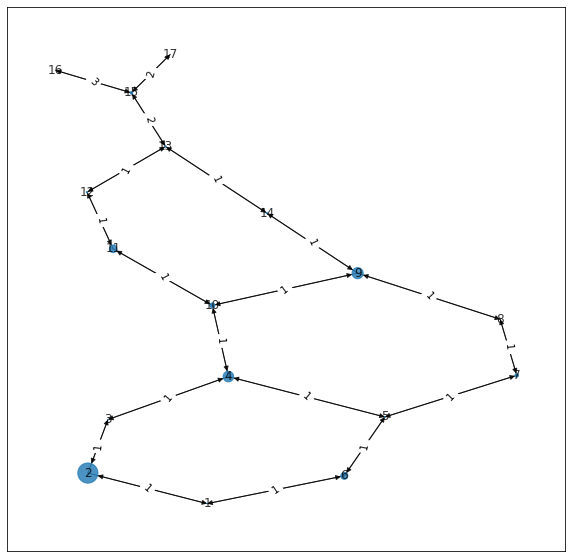

In [24]:
data = data_x[0]
label = data_y[0]
# 隣接行列
adjacency = Graph(data[0]).get_adjacency_matrix()
count = np.count_nonzero(adjacency)//2
# 量子ウォークのハイパーパラメータ
for step in range(1, 10):
    # 次数が2の場合のコインのパラメータ(今回は簡単のために全てアダマールコイン)
    coin = np.kron(np.identity(count), 1/np.sqrt(2)*np.array([[1, 1], [1, -1]]))
    # 初期状態 (0からスタート)
    initial = None 
    # 量子ウォーカーが測定される確率
    qwalk = QuantumWalk(initial, coin, adjacency)
    qwalk.n_steps(step)
    probs = qwalk.calc_probs()
    draw(probs)

やや見辛いですが、少しずつ観測される確率が広がっていっていることがわかると思います。

# 分類回路

これらを実際に量子回路に流して分類を行なっていきます。

In [67]:
from qwgc.preprocess.qwfilter import QWfilter
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, transpile
data = data_x[0]
label = data_y[0]
# filter
u3param = [pi, 0, pi/2]
# step
step = 3
# initial 重ね合わせを初期状態として利用
initial = "super"
qwfilter = QWfilter(u3param, step, initial)
# 今回は測定をせずに、振幅をそのまま量子回路にマッピングを行います。
amplitude = qwfilter.single_amplitude(data)

これにより特定のステップが終了した後の量子ウォークの確率振幅を取り出すことができました。これをqiskitのinitialize関数というものを用いて量子ビットに情報として入れていきます。またこの時$2^n$の大きさのベクトルである必要があることから0埋めを行います。

In [68]:
la = len(amplitude)
new_amplitude = list(amplitude) + [0 for i in range(64 - 38)]
print(len(new_amplitude))

64


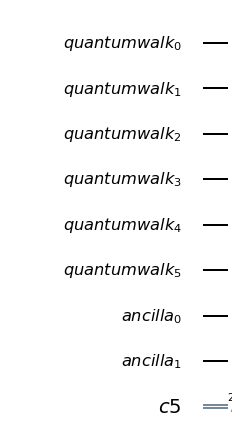

In [69]:
nq = 6
#　量子レジスタの定義
qr = QuantumRegister(nq, name="quantum walk")
ancilla = QuantumRegister(2, name="ancilla")
# 古典レジスタの定義
cr = ClassicalRegister(2)
# 量子回路の定義
qc = QuantumCircuit(qr, ancilla, cr)
qc.draw(output='mpl')

このように合計8量子ビットを用意しました。このうち上6つが量子ウォークのデータ（実際の実験ではこの部分が7個になっています。）、下2つが補助の量子ビットになっています。ここに量子ウォーク後の確率振幅を入れていきます。

In [70]:
qc.initialize(new_amplitude, qr)

そして、パラメータを初期化し、補助量子ビットに制御Ryゲートを用いてマッピングを行なっていきます。

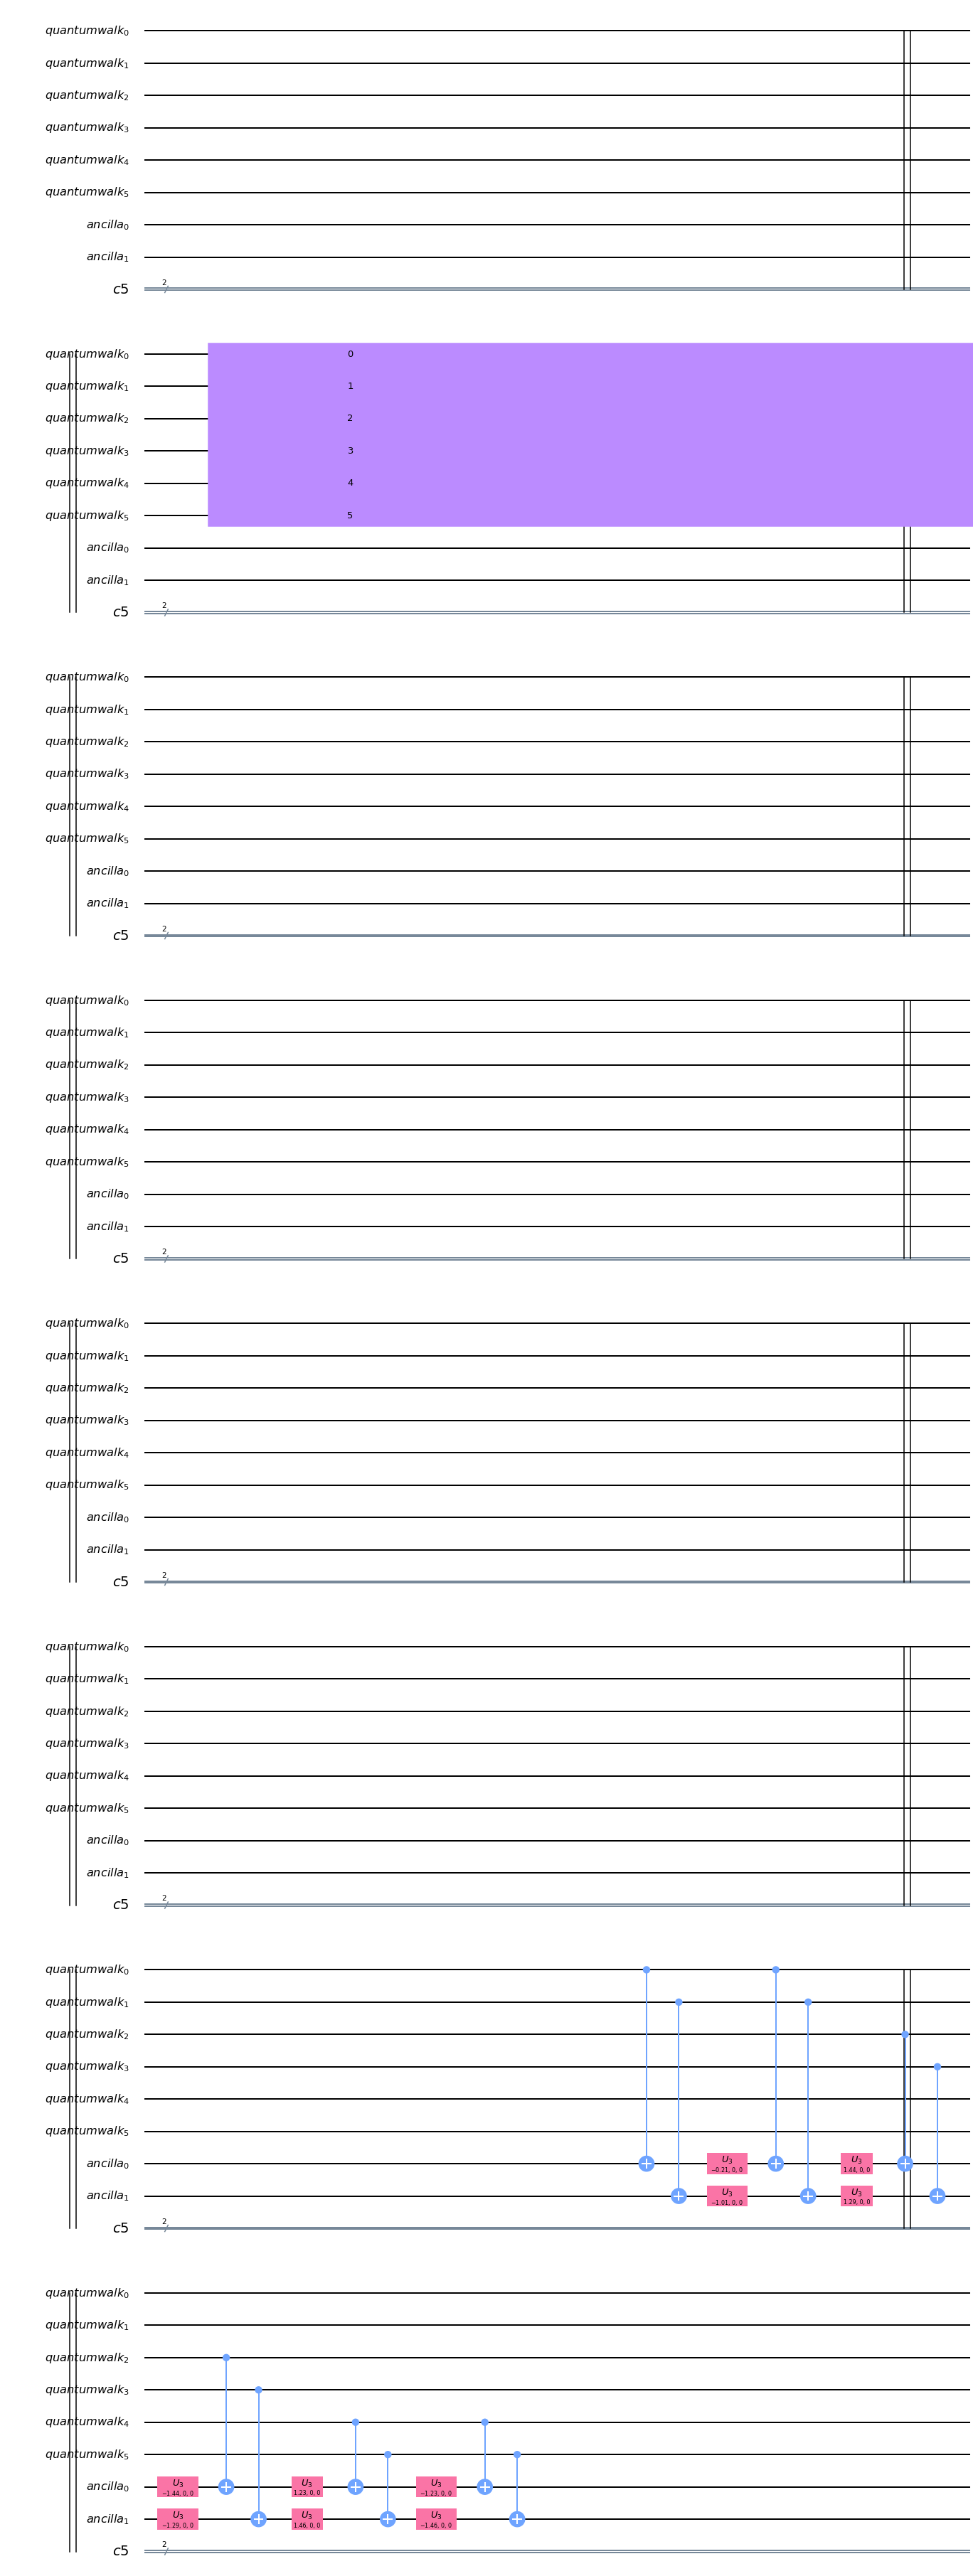

In [71]:
# 回転角を初期化
theta = [np.random.uniform(-pi, pi) for i in range(nq)]
for ith, th in enumerate(theta):
    qc.cry(th, qr[ith], ancilla[ith%2])
qc.draw(output="mpl")

最後に補助量子ビットを測定します。

In [72]:
qc.measure(ancilla, cr)

この測定によって、このグラフがどのクラスに分類されるのかということを見ていきます。今回は01をクラス-1、（つまり変異原性の性質が陰性）10をクラスの1(性質が陽性)とします。

In [75]:
backend = Aer.get_backend("qasm_simulator")
shots = 1024
job = execute(qc, backend=backend, shots=shots)
counts = job.result().get_counts(qc)
dinom = counts.get('01', 0) + counts.get('10', 0) + 1e-10
print("クラス-1である確率:", counts.get('01', 0)/dinom, "クラス1である確率:", counts.get('10', 0)/dinom)
if counts.get('01', 0)/dinom > counts.get('10', 0)/dinom:
    answer = -1
else:
    answer = 1
print("このグラフはクラス ", answer, "です.")

クラス-1である確率: 0.6064073226543235 クラス1である確率: 0.39359267734544773
このグラフはクラス  -1 です.


このような分類結果になります。これを実際のラベルと比較をしてみます。

In [77]:
print("正解は", data_y[1], "です。")

正解は -1 です。


これらを全てのデータに対して行い、エラーを計算し実際にパラメータのアップデートを行なっていきます。